# Trabajo Práctico 4 - Big data

# Grupo 17 - Elard Amaya, Federico Di Carlo, Clara Pasman, Rosario Podestá

# Parte 1 - Análisis de la base de hogares y cálculo de pobreza

### Limpiamos la EPH a nivel hogar e individual

**EPH a nivel hogar**: Como criterio generalizado borramos las variables que tienen muy poca variación, donde una o dos categorías similares concentraban más del 90% de la muestra (e.g. excluimos la variable ubicación del baño, dado que el 97% de hogares reportó tener el baño dentro de su vivienda). Por otro lado, mantenemos un conjunto de variables que podrían ser buenos predictores de la pobreza del hogar y que podrían complementar a las variables a nivel individual: N° de habitaciones de la vivienda, techo con cielorraso, cuarto para la cocina, lavadero y garage, dependencia del hogar en ingresos por trabajo, ingresos por jubilación, subsidios del gobierno, prestamos de amigos/familiares, compra en cuotas o al fiado con tarjeta de crédito/libreta, N° miembros del hogar y N° miembros menores a 10 años.

**EPH a nivel individidual**: Como criterio generalizado borramos todas las variables que tenian desde 50% de NA, muchas de estas corresponden a variables laborales, dado que solo registran respuestas para los individuos que trabajan. Asi mismo, optamos por borrar las variables relacionadas a la búsqueda de empleo y las variables categóricas de deciles de los distintos tipos de ingresos, dada la sensibilidad en el reporte de ingresos, y en caso se reporte solo corresponde para los individuos que trabajan.


In [1]:
#Importamos todo

import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import statsmodels.api as sm     
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # Para eliminar warnings

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures 
from scipy.special import expit
from sklearn import svm, tree
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from time import sleep
from tqdm.notebook import tqdm

In [2]:
#Limpieza de datos EPH a nivel hogar

pre_h = pd.read_excel('usu_hogar_T121.xlsx')

pre_h = pre_h[['CODUSU', 'NRO_HOGAR', 'IV2', 'IV5', 'II4_1', 'II4_2', 'II4_3', 'V1', 'V2', 'V5', 'V14', 'V16',
               'IX_TOT', 'IX_MEN10', 'PONDIH' ]]

pre_h = pre_h.loc[pre_h["II4_1"] != 0]  
pre_h = pre_h.loc[pre_h["V16"] != 9]  

pre_h.loc[(pre_h['IV2'] <3), 'IV2'] = 1
pre_h.loc[(pre_h['IV2'] >2) & (pre_h['IV2'] <5), 'IV2'] = 2
pre_h.loc[(pre_h['IV2'] >4), 'IV2'] = 3

pre_h.to_stata('eph_hogar.dta')  #Guardamos la EPH limpia a nivel hogar

#Limpieza de datos EPH a nivel individual

pre_i = pd.read_excel('usu_individual_T121.xlsx')

pre_i = pre_i.loc[:, ~pre_i.columns.str.startswith('PP02')]  #Vars relacionadas a busqueda de empleo (empiezan con PP02)
pre_i = pre_i.loc[:, ~pre_i.columns.str.startswith('PP')]  #Vars laborales con mas 50% NA
pre_i = pre_i.loc[:, ~pre_i.columns.str.endswith('UR')]  #Vars que indican deciles de ingreso (terminan en UR, DR, FR)
pre_i = pre_i.loc[:, ~pre_i.columns.str.endswith('DR')]
pre_i = pre_i.loc[:, ~pre_i.columns.str.endswith('FR')]  
pre_i = pre_i.drop(['CH05','CH15_COD','CH16_COD','IMPUTA','INTENSI','CH14'], axis=1)  #Vars con mas 80% NA, CH14 con 50% NA

pre_i.to_stata('eph_ind.dta')  #Guardamos la EPH limpia a nivel individual

### Creación de función para la limpieza final: solo GBA, merge de las EPH, creación de las nuevas variables y creación de bases finales

La función definida **"preprocesar_eph"** nos permite:

- Quedarnos con las observaciones de Ciudad Autonoma de Buenos Aires y Gran Buenos Aires (GBA, en adelante).
- Pegar las EPH de nivel individual y hogar, empleando como identificadores **CODUSU y NRO_HOGAR**.
- Borrar datos errados, cambiar vars string a numeric.
- Generar **dos variables relevantes** para predecir la pobreza: **proporción de personas con educación superior dentro del hogar y proporción de personas inmigrantes dentro del hogar**
- Pegar la tabla de adulto equivalente para cada individuo y el acumulado de hogar.
- Generar múltiples dataframe para la EPH, para los que reportan y no reportan ITF.
- Generar las variables ingreso_necesario y pobre.


In [3]:

def preprocesar_eph(eph_hogar, eph_ind, ad_equiv_xls):    
   
    '''
    params:
      eph_hogar: EPH a nivel hogar
      eph_ind: EPH a nivel individual
      ad_equiv_xls: tabla de adultos equivalentes
    
    return:
      eph, respondieron, norespondieron
    ''' 

    eph = pd.read_stata('eph_ind.dta')

    eph = eph[(eph['AGLOMERADO'] == 32) | (eph['AGLOMERADO'] == 33)]  #Muestra GBA
    eph = eph.loc[eph["CH06"]>-1]  #Borramos datos no coherentes
    eph = eph.loc[eph["P21"]>-1]  

    eph["IPCF"] = eph["IPCF"].apply(lambda x: float(x))  #Convertimos vars numericas
    eph["ITF"] = eph["ITF"].apply(lambda x: float(x))

    hogar = pd.read_stata('eph_hogar.dta')
    tabla = pd.read_excel('ad_equiv_xls.xlsx')
    
    eph = eph.merge(hogar, on=["NRO_HOGAR", "CODUSU"], how="left", suffixes=('', '_y'))  #Merge con EPH a nivel hogar
    eph = eph.merge(tabla, on=["CH04", "CH06"], how="left", suffixes=('', '_y'))  #Merge con tabla de equivalencia
    
    # Proporción de personas con educación superior dentro del hogar 
    
    eph.loc[(eph['CH12'] == 7) | (eph['CH12'] == 8), 'educ_sup'] = 1
    eph.loc[(eph['educ_sup'] != 1), 'educ_sup'] = 0
    eph['educ_sup_prop'] = eph['educ_sup']/eph['IX_TOT']
    
    educ_sup_hogar = eph[["educ_sup_prop", "CODUSU"]].groupby(by="CODUSU").agg({"educ_sup_prop":"sum"})
    educ_sup_hogar.reset_index(inplace = True)
    educ_sup_hogar.rename({"educ_sup_prop" : "educ_sup_hogar"}, inplace = True, axis="columns")
    
    eph = eph.merge(educ_sup_hogar, on="CODUSU", how="left", suffixes=('', '_y'))  #Prop. de educ. superior por hogar
    eph = eph.loc[:, ~eph.columns.str.startswith('_y')]
    
    # Proporción de personas inmigrantes dentro del hogar 

    eph.loc[(eph['CH15'] == 4) | (eph['CH15'] == 5), 'inmigrante'] = 1
    eph.loc[(eph['inmigrante'] != 1), 'inmigrante'] = 0
    eph['inmigrante_prop'] = eph['inmigrante']/eph['IX_TOT']
    
    inmigrantres_hogar = eph[["inmigrante_prop", "CODUSU"]].groupby(by="CODUSU").agg({"inmigrante_prop":"sum"})
    inmigrantres_hogar.reset_index(inplace = True)
    inmigrantres_hogar.rename({"inmigrante_prop" : "inmigrante_hogar"}, inplace = True, axis="columns")
    
    eph = eph.merge(inmigrantres_hogar, on="CODUSU", how="left", suffixes=('', '_y'))  #Prop. inmigrantes por hogar
    eph = eph.loc[:, ~eph.columns.str.startswith('_y')]
    
    eph = eph.drop(['educ_sup','educ_sup_prop','inmigrante','inmigrante_prop'], axis=1)  #Vars usadas para la generacion de nuevas var del hogar

    ad_equiv_hogar = eph[["adulto_equiv", "CODUSU"]].groupby(by="CODUSU").agg({"adulto_equiv":"sum"})
    ad_equiv_hogar.reset_index(inplace = True)
    ad_equiv_hogar.rename({"adulto_equiv" : "adulto_equiv_hogar"}, inplace = True, axis="columns")
    
    eph = eph.merge(ad_equiv_hogar, on="CODUSU", how="left", suffixes=('', '_y'))  #Merge con puntaje de equiv. a nivel hogar
    eph = eph.loc[:, ~eph.columns.str.startswith('_y')]
    eph = eph[(eph['V1'] == 1) | (eph['V1'] == 2)]  #Dropeando missings

    respondieron = eph[eph["ITF"] != 0]
    respondieron["ingreso_necesario"] = 18914 * respondieron["adulto_equiv_hogar"]
    respondieron["pobre"] = np.where(respondieron["ITF"] < respondieron["ingreso_necesario"], 1, 0)
    
    no_respondieron = eph[eph["ITF"] == 0]
    
    return eph, respondieron, no_respondieron


### Aplicación de la función preprocesar_eph

Usamos la EPH completa y describimos las dos nuevas variables: la proporción promedio de personas con educación superior dentro de los hogares es 17.7% y la proporción promedio de personas inmigrantes dentro de los hogares es 5.2%

Empleamos una matriz de correlación gráfica para una serie de variables. En general, encontramos que las variables seleccionadas tienen correlaciones bajas. 

       educ_sup_hogar  inmigrante_hogar
count     3536.000000       3536.000000
mean         0.178093          0.052675
std          0.289032          0.177301
min          0.000000          0.000000
25%          0.000000          0.000000
50%          0.000000          0.000000
75%          0.333333          0.000000
max          1.000000          1.000000


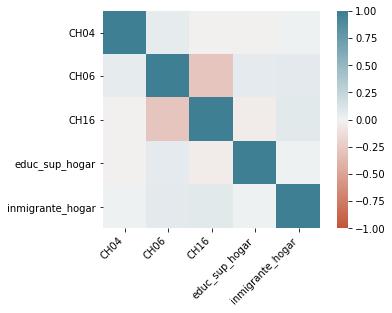

In [4]:
eph_hogar = "eph_hogar.dta"
eph_ind = "eph_ind.dta"
ad_equiv_xls = "ad_equiv_xls.xlsx"

eph, respondieron, no_respondieron = preprocesar_eph(eph_hogar, eph_ind, ad_equiv_xls)

print(eph[["educ_sup_hogar","inmigrante_hogar"]].describe())  #Estadisticas descriptivas de nuevas var

#Matriz de correlación

eph = pd.DataFrame(eph,columns=['CH04','CH06','CH16','educ_sup_hogar','inmigrante_hogar'])

corr = eph.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


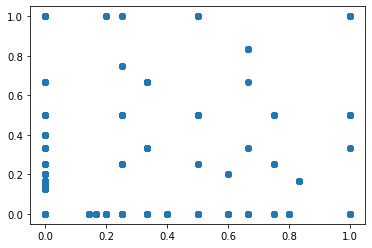

In [5]:
#Exploramos si hay algún tipo de corrleación marcada entre las variables creadas
plt.scatter(eph["educ_sup_hogar"],eph["inmigrante_hogar"])
#Observamos que no hay correlación, tal como lo expresa la matriz de correlaciones 

Usamos la base "respondieron", nos quedamos con el jefe del hogar y usamos el ponderador de la EPH para obtener un estimado poblacional de la pobreza. **El INDEC reporta una tasa de pobreza a nivel hogar de 30.5% en GBA**. Nuestra estimación nos muestra una **tasa de pobreza 30.12%**, bastante similar a la cifra oficial de INDEC. 

In [6]:
pobreza_h = respondieron[respondieron["CH03"] == 1]

print('Pobreza estimada (usando jefe de hogar):')
print(np.average(pobreza_h["pobre"], weights=pobreza_h["PONDIH"]))  #Proporción de hogares en condición de pobreza


Pobreza estimada (usando jefe de hogar):
0.30124326459118383


# Parte 2 - Construcción de funciones

Primero generamos diccionarios con los modelos a utilizar. Cada modelo se encuentra caracterizado por los parámetros correspondientes. 
Luego definimos la función la cual toma como inputs a los modelos y la base de datos, y produce métricas de evaluación para dichos modelos. Esto nos permite comparar modelos según, entre otros, su precisión predictiva.

In [18]:
model_list = [LinearDiscriminantAnalysis, KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier,
               AdaBoostClassifier, BaggingClassifier, LinearSVC]

#Para log reg models
log_reg_type = {
    "ELASTIC": {"penalty":"elasticnet","solver":"saga", "l1_ratio":0.5},
    "LASSO": {"penalty":"l1", "solver":"saga"}, 
    "RIDGE": {"penalty":"l2", "solver":"lbfgs"}, 
    
    }

#Llenar esto de configs a probar
# {parameter, range}
testingparams = {LinearDiscriminantAnalysis : ["n_components", (1,2)], 
                LogisticRegression: ["C", (1,11)], 
                KNeighborsClassifier: ["n_neighbors", (1,11)],
                DecisionTreeClassifier: ["max_features", (1,8)],
                RandomForestClassifier: ["n_estimators", (95,105)],
                AdaBoostClassifier: ["n_estimators", (47,52)],
                BaggingClassifier: ["n_estimators", (7,12)],
                LinearSVC: ["max_iter", (1000,1050)]
    }

In [20]:

def evalua_modelo(model, X_train, y_train, X_test, y_test):
    """Fitea un modelo dado a la data que se le brinda.
    Args:
        model: [Modelo a fitear]
        X_train: [Datos de entrenamiento para las variables independientes]
        y_train: [Datos de entrenamiento para las variables dependientes]
        X_test: [Datos de testeo para las variables independientes]
        y_test: [Datos de testeo para las variables dependientes]

    Returns:
        Dict: [Un diccionario con las siguientes entradas: Accuracy, ECM, Matriz de Confusión, AUC y curva ROC. ]
    """
    # Fiteamos el
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metricas
     
    ecm = mean_squared_error(y_pred, y_test)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    auc = roc_auc_score(y_test, y_pred)
    roc_curve_data = roc_curve(y_test, y_pred)

    return {"accuracy": accuracy, "ecm": ecm, "matriz_confusion": matriz_confusion, "auc": auc, "roc_curve_data": roc_curve_data}
    

In [21]:
def cross_validation(model, X, y, k=10):
    """    Esta función realiza una validación cruzada de forma iterada para los resultados
    de la función evalua_metodo
    

    Args:
        model: [Modelo a iterar]
        X: [Datos de las variables independientes]
        y: [Datos de las variables dependientes]
        k: [Iteraciones]. Defaults to 10.

    Returns:
        [Dataframe]: [Dataframe con metricas de todas las iteraciones]
    """


    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    partition, accuracy, ecm, matriz_confusion, auc, roc_curve_data = ([] for i in range(6))
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        metrics = evalua_modelo(model, X_train, y_train, X_test, y_test)  ##Aca cambie evalua_modelo
        
        partition.append(int(i))
        accuracy.append(metrics["accuracy"])
        ecm.append(metrics["ecm"])
        matriz_confusion.append(metrics["matriz_confusion"])
        auc.append(metrics["auc"])
        roc_curve_data.append(metrics["roc_curve_data"])
        

    return pd.DataFrame({"partition":partition,
                         "accuracy":accuracy,
                         "ecm":ecm,
                         "matriz_confusion":matriz_confusion,
                         "auc":auc,
                         "roc_curve_data":roc_curve_data})

In [22]:
def evalua_config(X, y, model, testing_key_word, param_list_to_test, extraparams={}):
    """ Evalúa distintas configuraciones para los modelos, de forma tal de lograr obtener el menor error promedio. 

    Args:
        X : [Datos de las variables independientes]
        y : [Datos de las variables dependientes]
        model: [Modelo a evaluar]
        param_list_to_test: [Parámetros a testear]. 
        extraparams: [Otros parámetros no testeados]. Defaults to None.

    Returns:
        list: [description]
    """
   
    def get_mean_error(df, meassure="accuracy"):
        """Recupera la media del accuracy score de un dataframe determinado, que cuente con dicha medida. 

        Args:
            df ([Dataframe]): Dataframes que surgen de la función cross_validation.
            meassure (str): Datos para calcular la media. Defaults to "accuracy".
        
        Returns:
            Valor: [Media de accuracy score para el dataframe seleccionado]
        """
        return np.mean(df[meassure])
    
    list_error_dfs = [cross_validation(model(**{testing_key_word: p}, **extraparams), X, y, k=10)
                      for p in param_list_to_test]
        
    mean_accuracy_list = [get_mean_error(df) for df in list_error_dfs]    
    index_of_min_error = mean_accuracy_list.index(max(mean_accuracy_list))  
         
    return param_list_to_test[index_of_min_error], list_error_dfs[index_of_min_error]

In [23]:
def evalua_multiples_metodos(X, y, model_list):
   """Una función que devuelve para cada modelo, la mejor configuración dados los resultados de evaluar_config y
        cross_validation y el error promedio mínimo.  

    Args:
        X: [Datos de las variables independientes]
        y: [Datos de las variables dependientes]
        model_list: [Lista de modelos]
    Returns:
        Valor: [Media de accuracy score para el dataframe seleccionado]
    """
   
   evalua_df =  pd.DataFrame(columns=["partition", "accuracy", "ecm", 
                                      "matriz_confusion", "auc", "roc_curve_data",
                                      "Configuración", "Modelo"])

   for model in tqdm(model_list):
      testing_key_word = testingparams[model][0]  # {Parámetros} [corresponde al objeto modelo]
      min_test, max_test = testingparams[model][1] # Rangos [corresponde al objeto rangos]
      if model==LogisticRegression: # Como hay tres casos para LogisticRegression, se hace un if
         for penalty_type in log_reg_type:
            extraparams = log_reg_type[penalty_type]
            params_to_test = [i for i in range(min_test, max_test )]
            min_parameter, df_error= evalua_config(X, y, model, 
                                                      testing_key_word = testing_key_word,
                                                      param_list_to_test=params_to_test, 
                                                      extraparams = extraparams)
            config = f"{testing_key_word} = {min_parameter}, {penalty_type}"
            df_error["Configuración"] = config
            df_error["Modelo"] = model.__name__
            evalua_df = pd.concat([evalua_df, df_error], ignore_index=True)
      else:
         params_to_test = [i for i in range(min_test, max_test )] 
         min_parameter, df_error = evalua_config(X, y, model, 
                                                   testing_key_word = testing_key_word,
                                                   param_list_to_test=params_to_test)
         config = f"{testing_key_word} = {min_parameter}"
         
         df_error["Configuración"] = config
         df_error["Modelo"] = model.__name__
      
         evalua_df = pd.concat([evalua_df, df_error], ignore_index=True)
   
   evalua_df = evalua_df
   
   return evalua_df.loc[evalua_df.groupby(["Modelo", "Configuración"])['accuracy'].idxmax()].reset_index()
                                   

# Parte 3 - Clasificación y Regularización

### Creación de función para eliminar las variables relacionadas al ingreso

La función definida **"generar_base_prediccion"** nos permite eliminar las variables relacionadas al ingreso, las variables adulto_equiv, ad_equiv_hogar e ingreso_necesario, establecer las variable "pobre" como el vecto Y y al resto de variables como la matriz de variables independientes.

In [24]:

def generar_base_prediccion(df):

    '''
    params:
      df: DataFrame de Pandas con la EPH preprocesada 
        
    return:
      Si df contiene una columna llamada "pobre" devuelve dos datasets: X (los predictores) e y (las etiquetas). 
      Si no, solamente devuelve X
    '''

    columns_to_drop = ['ITF','IPCF','PONDIH','P21','TOT_P12','P47T','V2_M','V3_M','V4_M','V5_M','V8_M',
                       'V9_M','V10_M','V11_M','V12_M','V18_M','V19_AM','V21_M','T_VI','adulto_equiv', 
                       'adulto_equiv_hogar','ANO4','TRIMESTRE']    
    base_prediccion = df.drop(columns=columns_to_drop)
    if 'ingreso_necesario' in base_prediccion.columns:
        base_prediccion.drop(columns=['ingreso_necesario'])
    base_prediccion = base_prediccion.drop(columns=["CODUSU", "MAS_500"])
    base_prediccion = base_prediccion.dropna(thresh = len(base_prediccion), axis = 1)
    base_prediccion["cons"] = 1
    if 'pobre' in base_prediccion.columns:
        return base_prediccion.drop(columns=["pobre"]), base_prediccion.pobre
    else:
        return base_prediccion
    

In [49]:
X, y = generar_base_prediccion(respondieron)

In [102]:
X = respondieron.drop(['pobre','CODUSU','MAS_500','P47T','ingreso_necesario'], axis=1)
y = respondieron["pobre"] 

In [103]:
df_test=evalua_multiples_metodos(X, y, model_list)
df_test

  0%|          | 0/8 [00:00<?, ?it/s]

,index,partition,accuracy,ecm,matriz_confusion,auc,roc_curve_data,Configuración,Modelo
0,71,1,1.00000,0.00000,"[[167, 0], [0, 83]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_estimators = 51,AdaBoostClassifier
1,81,1,1.00000,0.00000,"[[167, 0], [0, 83]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_estimators = 10,BaggingClassifier
2,52,2,0.98400,0.01600,"[[174, 3], [1, 72]]",0.984676,"([0.0, 0.01694915254237288, 1.0], [0.0, 0.9863...",max_features = 7,DecisionTreeClassifier
3,15,5,0.97200,0.02800,"[[177, 4], [3, 66]]",0.967211,"([0.0, 0.022099447513812154, 1.0], [0.0, 0.956...",n_neighbors = 1,KNeighborsClassifier
4,2,2,0.87600,0.12400,"[[161, 16], [15, 58]]",0.852063,"([0.0, 0.0903954802259887, 1.0], [0.0, 0.79452...",n_components = 1,LinearDiscriminantAnalysis
5,90,0,0.98400,0.01600,"[[165, 3], [1, 81]]",0.984974,"([0.0, 0.017857142857142856, 1.0], [0.0, 0.987...",max_iter = 1001,LinearSVC
6,21,1,0.96000,0.04000,"[[159, 8], [2, 81]]",0.964000,"([0.0, 0.04790419161676647, 1.0], [0.0, 0.9759...","C = 1, ELASTIC",LogisticRegression
7,31,1,0.96000,0.04000,"[[159, 8], [2, 81]]",0.964000,"([0.0, 0.04790419161676647, 1.0], [0.0, 0.9759...","C = 1, LASSO",LogisticRegression
8,49,9,0.97992,0.02008,"[[154, 3], [2, 90]]",0.979576,"([0.0, 0.01910828025477707, 1.0], [0.0, 0.9782...","C = 1, RIDGE",LogisticRegression
9,61,1,1.00000,0.00000,"[[167, 0], [0, 83]]",1.000000,"([0.0, 0.0, 1.0], [0.0, 1.0, 1.0], [2, 1, 0])",n_estimators = 96,RandomForestClassifier


Dados los resultados obtenidos, el modelo que mejor predice la pobreza a partir de la educación superior del jefe de hogar es el de Logistic Regression con un C igual a 6, elegido por regularización co RIDGE. Como se muestra en la tabla, la accuracy del mismo es 1. Además el error cuadrático medio es 0, por lo que el modelo minimiza al mismo. Al hacerlo, se convierte en la mejor vía para predecir la pobreza en base al resultado educativo utilizado. Por más que los valores de dichas métricas coinciden con las de otros modelos, creemos que el modelo elegido es óptimo para predecir en el caso de variables altamente correlacionadas, como las que presenta la EPH.  

Con el modeo seleccionado, predeciremos cuantos pobres hay en la muestra "no respondieron". 

In [71]:
generar_base_prediccion(no_respondieron)

#no_respondieron = no_respondieron[(no_respondieron['V1'] == 1) | (no_respondieron['V1'] == 2)]  #Dropeando missings

#X_nr = no_respondieron.drop(['CODUSU','MAS_500','P47T'], axis=1).astype('float64')
#y = respondieron["pobre"] 

,index,NRO_HOGAR,COMPONENTE,H15,REGION,AGLOMERADO,PONDERA,CH03,CH04,CH06,...,V2,V5,V14,V16,IX_TOT,IX_MEN10,PONDIH_y,educ_sup_hogar,inmigrante_hogar,cons
2,36801,1,1,1,1,32,3090,1,1,54,...,2.0,2.0,2.0,1.0,5.0,0.0,0.0,0.8,0.000000,1
3,36802,1,2,1,1,32,3090,2,2,53,...,2.0,2.0,2.0,1.0,5.0,0.0,0.0,0.8,0.000000,1
4,36803,1,3,1,1,32,3090,3,2,22,...,2.0,2.0,2.0,1.0,5.0,0.0,0.0,0.8,0.000000,1
5,36804,1,4,1,1,32,3090,3,1,19,...,2.0,2.0,2.0,1.0,5.0,0.0,0.0,0.8,0.000000,1
6,36805,1,5,1,1,32,3090,3,1,13,...,2.0,2.0,2.0,1.0,5.0,0.0,0.0,0.8,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3517,40846,1,6,0,1,33,7083,3,1,5,...,2.0,2.0,2.0,2.0,7.0,3.0,0.0,0.0,0.142857,1
3518,40847,1,7,0,1,33,7083,3,1,3,...,2.0,2.0,2.0,2.0,7.0,3.0,0.0,0.0,0.142857,1
3542,40872,1,2,1,1,33,944,2,1,70,...,1.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.000000,1
3543,40873,1,1,1,1,33,944,1,2,61,...,1.0,2.0,2.0,2.0,3.0,0.0,0.0,0.0,0.000000,1


In [105]:
X = respondieron.drop(['pobre','CODUSU','MAS_500','P47T','ingreso_necesario'], axis=1)
y = respondieron["pobre"] 
X_nr = no_respondieron.drop(['pobre','CODUSU','MAS_500','P47T'], axis=1)

In [107]:
log_reg = LogisticRegression(C=6.0).fit(X, y)
y_pred_nr = log_reg.predict(X_nr)

no_respondieron["pobre"] = y_pred_nr

print(no_respondieron["pobre"].describe())  #Estadisticas descriptivas de pobreza


count    1037.000000
mean        0.999036
std         0.031054
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: pobre, dtype: float64


Predecimos que hay ..... de pobres en la muestra no_respondieron. 